In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
%matplotlib inline

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from googletrans import Translator
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In reviewing the data description and a quick glance at the dataframe, it is clear that almost all variables are categorical. Breakdown as follows:

- Time Variables - 1
- Categorical Variables - 13
- Ordinal Variables - 2
- Binary Target - 1

To review each variable in detail, we can use Pandas Profiling as seen below. 

In [2]:
# Review Data Overall - Missingness, Cardinality, Etc
df = pd.read_pickle('anon_df.pkl')
ProfileReport(df)

Number of variables,17
Number of observations,101115
Total Missing (%),19.8%
Total size in memory,13.1 MiB
Average record size in memory,136.0 B
Numeric,7
Categorical,9
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Categorical Variable Distributions

To get a better sense of the distributions, specifically that of categorical variables, I've plotted each level of each variable with the proportion of conversions to see whether there are specific levels that relate most to conversion. 

Feature: other_cat1, Unique Vals: 22
Feature: other_cat2, Unique Vals: 153
Feature: other_cat3, Unique Vals: 57
Feature: other_cat4, Unique Vals: 76
Feature: location3, Unique Vals: 8
Feature: location2, Unique Vals: 201
Feature: location1, Unique Vals: 11165
Feature: location4, Unique Vals: 372
Feature: location5, Unique Vals: 33
Feature: other_cat5, Unique Vals: 60
Feature: sector1, Unique Vals: 31
Feature: sector2, Unique Vals: 10


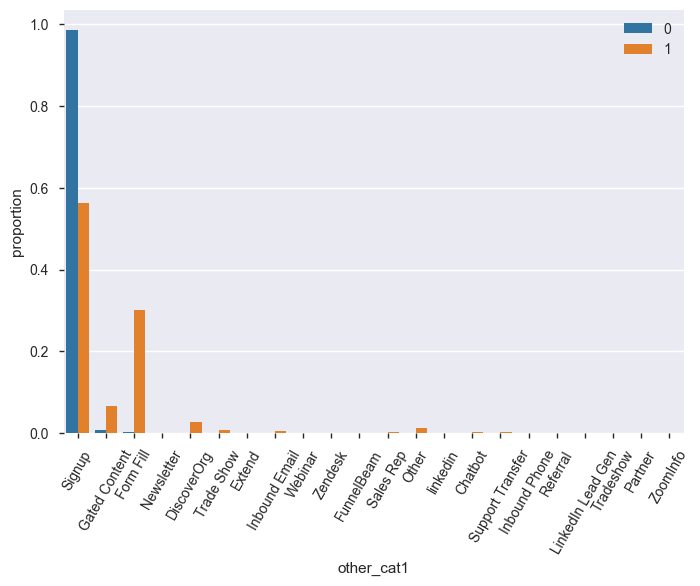

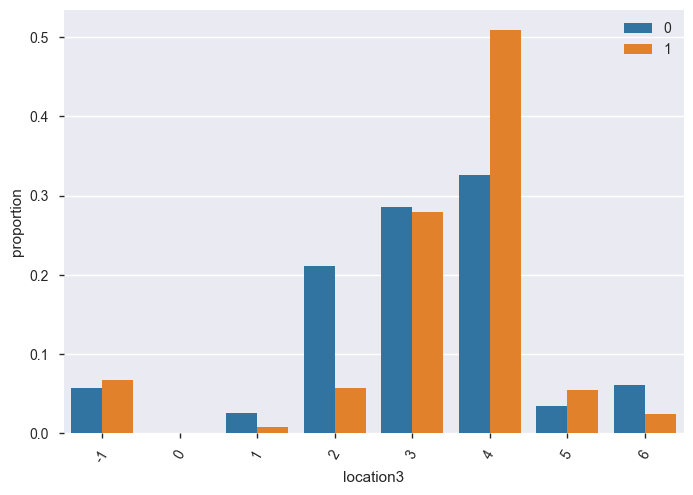

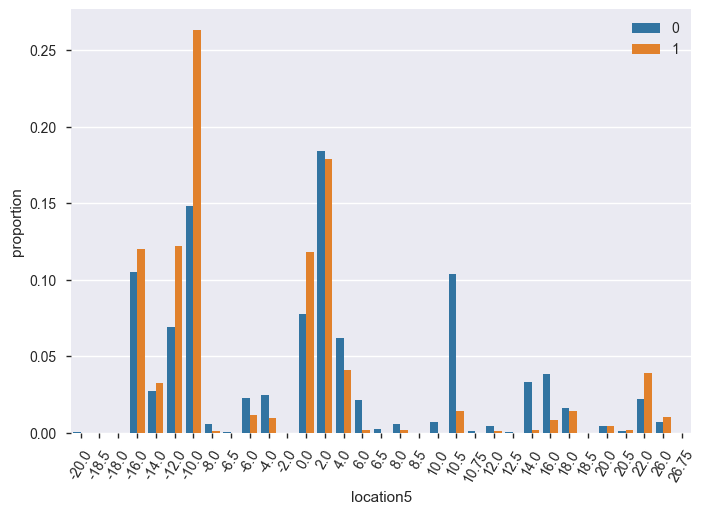

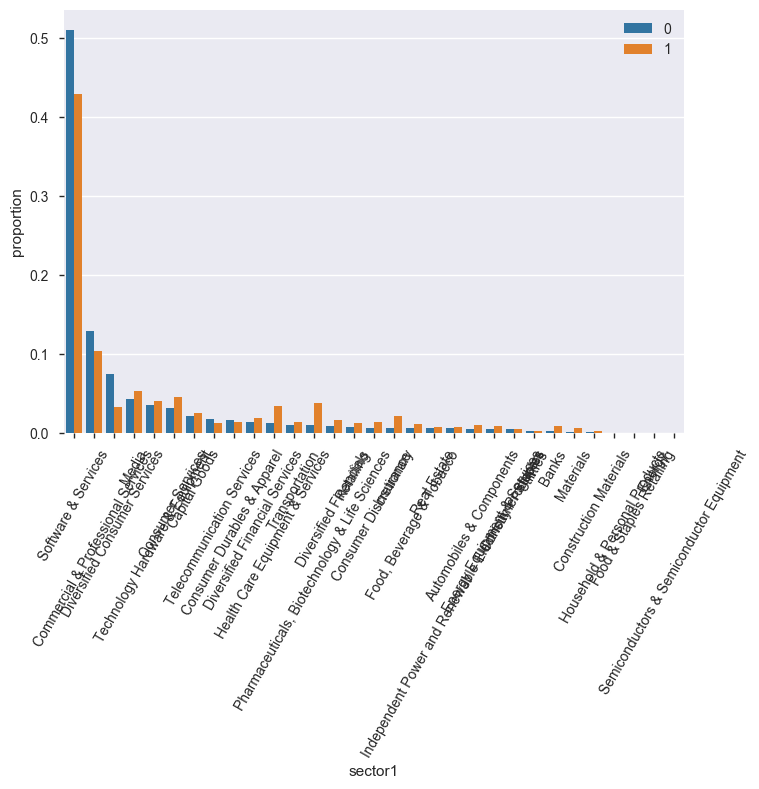

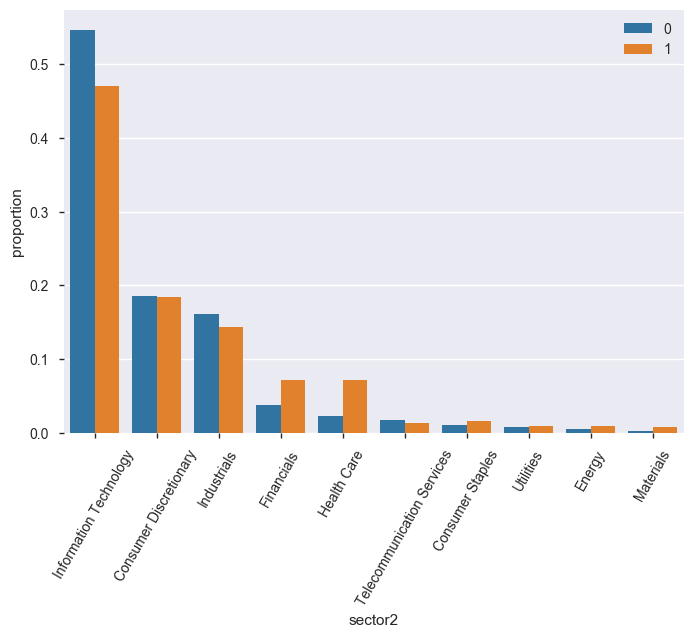

In [3]:
# Create plotting method
def categorical_plot(col, y='proportion', hue='label'):
    a = (df[col]
         .groupby(df[hue])
         .value_counts(normalize=True)
         .rename(y)
         .reset_index())
    # Plot
    chart = sns.barplot(x=col, y=y, hue=hue, data=a)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
    plt.legend(loc='upper right')
    plt.show()
    
    
# Define categorical columns
cat_cols = [x for x in df.columns if x.startswith('other_cat')| x.startswith('location')| x.startswith('sector')]

# Review categorical columns
for col in cat_cols:
    print('Feature: {}, Unique Vals: {}'.format(col, len(df[col].value_counts())))
    
# Plot categorical column conversion comparison (less than 40 levels)
y, hue = "proportion", "label"
hue_order = [0,1]

for col in cat_cols:
    if len(df[col].value_counts())<40:
        categorical_plot(col)

As seen in the plots above, some variables have an high amount of levels. Within those with 40 or less levels, most converted vs. non-converted levels have similar proportions within that of the variable. For those levels in which the conversion rate is much higher in comparison to other levels, the percentages are not overwhelming. 


Next we can start to review individual categorical variables and incorporate thresholds to include if the frequency of certain levels are much lower. For this section, I am focusing on those labeled 'other categories'. 

In [4]:
### Review variables to bucket 

#### Other1
df.other_cat1 = [str(x) for x in df.other_cat1]
pd.crosstab(df.other_cat1, df.label)
df.other_cat1.value_counts()
# Based on results and no direct correlation between lower level sources and conversion, group >100 as other

#### Other2
df.other_cat2 = [str(x) for x in df.other_cat2]
pd.crosstab(df.other_cat2, df.label)
df.other_cat2.unique()
df['other_cat2'] = [x.split('|')[0].strip() if '|' in x else x for x in df.other_cat2]
df['other_cat2'] = [x.split(' ')[0].strip() if ' ' in x else x for x in df.other_cat2]
pd.crosstab(df.other_cat2, df.label)
# WF = highest conversion rate
## Group together lower-level campaigns

### Other3
df.other_cat3.value_counts()
# Convert those >100 to other

### Other4
df.other_cat4 = [str(x) for x in df.other_cat4]
# Group by overall grouping - first word
df['other_cat4'] = [x.split(' ')[0] for x in df.other_cat4]
# Convert those >100 to other

### Other5
# Get title names
titles = df.other_cat5.value_counts().index
# Instantiate translator, extract non english titles
translator = Translator()
langs = [translator.detect(titles[x]).lang for x in range(len(titles))]
non_eng = [x for x in range(len(langs)) if langs[x]!= 'en']
non_eng_titles = [titles[x] for x in non_eng]
# Translate titles
translated_titles = [translator.translate(x).text for x in non_eng_titles]
# Create dictionary
title_dct = dict(zip(non_eng_titles, translated_titles))
# Replace in role column
df['other_cat5'] = df.other_cat5.replace(title_dct)

# Lower to match
df.other_cat5 = [str(x) for x in df.other_cat5]
df.other_cat5 = [x.lower() for x in df.other_cat5]

# Create groupings
df.other_cat5 = ['developer' if 'develop' in x and x!='non-developer' else x for x in df.other_cat5]
df.other_cat5 = ['engineering' if 'engineer' in x else x for x in df.other_cat5]
df.other_cat5 = ['other' if 'unknown' in x else x for x in df.other_cat5]
df.other_cat5 = ['other' if 'other' in x else x for x in df.other_cat5]
c_levels = ['c-level', 'ceo', 'founder', 'owner', 'president', 'leadership']
df.other_cat5 = df.other_cat5.replace(c_levels, 'c-level')
df.other_cat5 = ['product' if 'product' in x else x for x in df.other_cat5]
df.other_cat5 = ['operations' if 'operations' in x else x for x in df.other_cat5]
df.other_cat5.value_counts()
# Replace with freq <100

## Input 'Other' Threshold
for col in [x for x in df.columns if x.startswith('other')]:
    df[col] = df[col].replace(list(df[col].value_counts()
                                          .reset_index(name="count")
                                          .query("count < 100")["index"]), 'Other')

Next I will review time data. Given that the dataset has grown significantly since the start of the data, it makes sense that the number of leads, both converted and non-converted, has grown. I do not think it empirically makes sense to include time data within the model given that new leads will not be coming in within the years given. However, it make make sense to include month data to incorporate seasonality affects. 

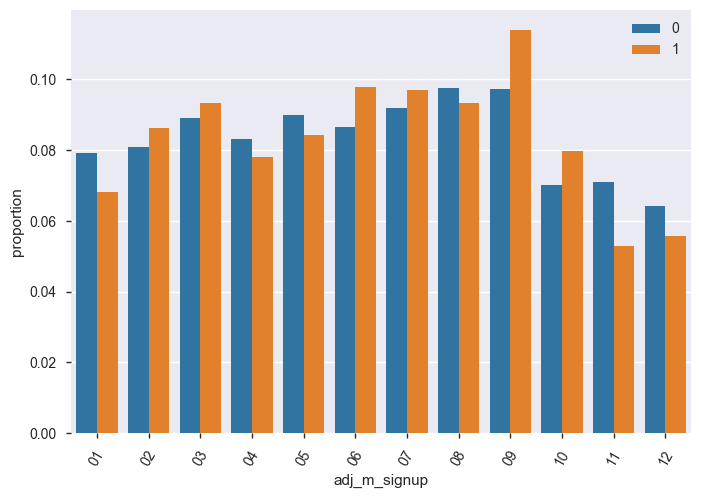

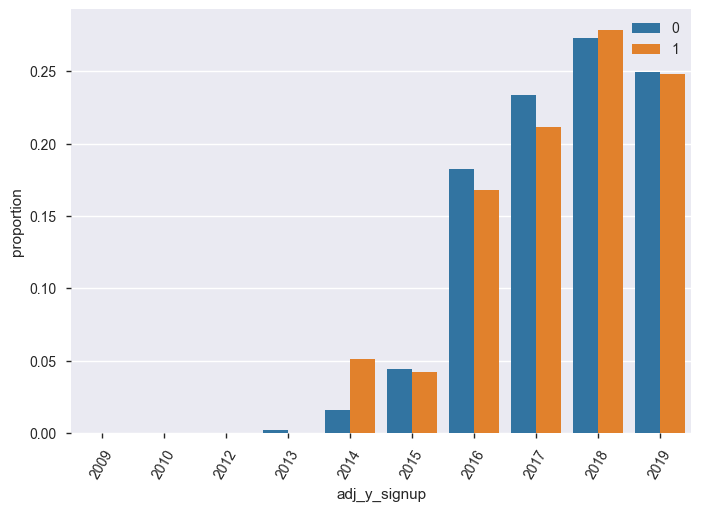

In [5]:
# Convert signup to datetime - month year, and year
df['adj_my_signup'] = pd.to_datetime(df['signup_date']).map(lambda x: x.strftime('%Y-%m'))
df['adj_y_signup'] = pd.to_datetime(df['signup_date']).map(lambda x: x.strftime('%Y'))
df['adj_m_signup'] = pd.to_datetime(df['signup_date']).map(lambda x: x.strftime('%m'))

categorical_plot('adj_m_signup')
categorical_plot('adj_y_signup')

## Categorical Correlations

Given that the data is mostly categorical, using basic correlation methods will not work well. We can use a Cramers V matrix to gather correlation data for each categorical variable pair. 

In [6]:
# Review categorical corrs
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

corr_dct = {}

for primary in cat_cols:
    corr_lst = []
    for secondary in cat_cols:
        confusion_matrix = pd.crosstab(df[primary], df[secondary]).as_matrix()
        corr_lst.append(cramers_v(confusion_matrix))
    corr_dct.update({primary:corr_lst})

# Create df
corr_df = pd.DataFrame.from_dict(corr_dct, orient='index',columns=cat_cols)
corr_df.style.applymap(lambda x: 'background-color : yellow' if x>0.7 else '')

,other_cat1,other_cat2,other_cat3,other_cat4,location3,location2,location1,location4,location5,other_cat5,sector1,sector2
other_cat1,1,0.665829,0.120085,0.180437,0.0972098,0.106162,0.268906,0.201191,0.185415,0.113366,0.0618682,0.0363747
other_cat2,0.665829,1,0.0980258,0.14729,0.0725487,0.0804806,0.201197,0.150553,0.135109,0.0974858,0.0497655,0.0301193
other_cat3,0.120085,0.0980258,1,0.294774,0.0996487,0.0719779,0.150416,0.0690043,0.0512368,0.0993972,0.030158,0.0391209
other_cat4,0.180437,0.14729,0.294774,1,0.346826,0.278318,0.29997,0.262491,0.147066,0.115671,0.0301239,0.0234246
location3,0.0972098,0.0725487,0.0996487,0.346826,1,0.999045,0.830159,0.656081,0.770654,0.113785,0.107175,0.0732965
location2,0.106162,0.0804806,0.0719779,0.278318,0.999045,1,0.863842,0.330133,0.804169,0.0884619,0.0708085,0.0922652
location1,0.268906,0.201197,0.150416,0.29997,0.830159,0.863842,1,0.89565,0.896052,0.108122,0.192622,0.192573
location4,0.201191,0.150553,0.0690043,0.262491,0.656081,0.330133,0.89565,1,0.62651,0.104161,0.0745221,0.0899292
location5,0.185415,0.135109,0.0512368,0.147066,0.770654,0.804169,0.896052,0.62651,1,0.0579706,0.0555916,0.0745689
other_cat5,0.113366,0.0974858,0.0993972,0.115671,0.113785,0.0884619,0.108122,0.104161,0.0579706,1,0.05236,0.0340317


Based on categorical correlations, there are two larger segments to look at: location and company category type.

In [7]:
# Review location elements of dataframe
locations = [x for x in df.columns if x.startswith('location')]

for col in locations:
    print('Feature: {}, Unique Vals: {}'.format(col, len(df[col].value_counts())))

corr_df.filter(locations, axis=0).filter(locations, axis=1).style.applymap(lambda x: 'background-color : yellow' if x>0.8 else '')

Feature: location3, Unique Vals: 8
Feature: location2, Unique Vals: 201
Feature: location1, Unique Vals: 11165
Feature: location4, Unique Vals: 372
Feature: location5, Unique Vals: 33


,location3,location2,location1,location4,location5
location3,1,0.999045,0.830159,0.656081,0.770654
location2,0.999045,1,0.863842,0.330133,0.804169
location1,0.830159,0.863842,1,0.89565,0.896052
location4,0.656081,0.330133,0.89565,1,0.62651
location5,0.770654,0.804169,0.896052,0.62651,1


Given the above information, it would make sense to drop location1 given its high cardinality and high correlation with other location-specific variables. location2 code additionally is highly correlated with the remaining location variables, so we can drop that as well while keeping the remaining location variables. 


We can now review the other columns in more detail again. 

In [8]:
### Compare others
(corr_df
 .filter([x for x in corr_df if x not in locations], axis=0)
 .filter([x for x in corr_df if x not in locations], axis=1)
 .style.applymap(lambda x: 'background-color : yellow' if x>0.8 else ''))

,other_cat1,other_cat2,other_cat3,other_cat4,other_cat5,sector1,sector2
other_cat1,1,0.665829,0.120085,0.180437,0.113366,0.0618682,0.0363747
other_cat2,0.665829,1,0.0980258,0.14729,0.0974858,0.0497655,0.0301193
other_cat3,0.120085,0.0980258,1,0.294774,0.0993972,0.030158,0.0391209
other_cat4,0.180437,0.14729,0.294774,1,0.115671,0.0301239,0.0234246
other_cat5,0.113366,0.0974858,0.0993972,0.115671,1,0.05236,0.0340317
sector1,0.0618682,0.0497655,0.030158,0.0301239,0.05236,1,0.999546
sector2,0.0363747,0.0301193,0.0391209,0.0234246,0.0340317,0.999546,1


The two sector groups are highly correlated, as the first is a more detailed version of the second. It makes sense to only keep one, so it comes down to the difference in the levels in regard to conversion behavior. 

In [9]:
# Review connection
pd.crosstab(df.sector1, df.sector2)

# Categories with multi industry: Consumer Discretionary, Consumer Staples, 
## Financials, Health Care, Industrials, Information Technology

# Compare internal conversion rates - if wildly variant, include all industry groups, else category
secs = ['Consumer Discretionary', 'Consumer Staples', 'Financials', 
        'Health Care', 'Industrials', 'Information Technology']

# Review each section
for sec in secs:
    print(sec)
    x = (pd.crosstab(df.sector1[df.sector2==sec], df.label)
         .apply(lambda r: r/r.sum(), axis=1))
    print(x)
    print('\n')
    
# Financials seem to have the biggest gap, review counts
pd.crosstab(df.sector1[df.sector2=='Financials'], df.label)

Consumer Discretionary
label                                 0         1
sector1                                          
Automobiles & Components       0.925620  0.074380
Consumer Discretionary         0.922581  0.077419
Consumer Durables & Apparel    0.967213  0.032787
Consumer Services              0.948993  0.051007
Diversified Consumer Services  0.983626  0.016374
Media                          0.955796  0.044204
Retailing                      0.940541  0.059459


Consumer Staples
label                                 0         1
sector1                                          
Consumer Staples               0.961538  0.038462
Food & Staples Retailing       1.000000  0.000000
Food, Beverage & Tobacco       0.932432  0.067568
Household & Personal Products  1.000000  0.000000


Financials
label                                  0         1
sector1                                           
Banks                           0.881356  0.118644
Diversified Financial Services  0.952802  

label,0,1
sector1,,
Banks,52,7
Diversified Financial Services,323,16
Diversified Financials,205,14
Insurance,142,18
Real Estate,131,6


Within umbrella sectors, the industry groups within the Financial sector seem to have the most variance in regard to conversion. However, reviewing the sector more closely, the largest differentiator seems to be about 10%, which may be too small of a difference to include each specific industry group. Moving forward, I will keep in sector2. 

## Ordinal Variable Distributions

We can next move on to reviewing ordinal variables. Initially, I had planned to bucket both variables given the somewhat seemingly bucketed nature of each, but after receiving further information from the client, it seems best to keep both continuous. 

To approach these variables, I will review their distributions, coerce outliers, and explore various transformations to try to normalize. 

In [10]:
#### Transformations - log, sqrt, reciprocal, boxcox

def transformation_grid(feat):
    
    # Set Figure
    fig = plt.figure(figsize=(10, 8))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    
    # Set Initial
    ax = fig.add_subplot(2, 3, 1)
    sns.distplot(feat, rug=True, hist=False).set_title('Untransformed Data')
    
    # Set Overall BC
    ax = fig.add_subplot(2, 3, 2)
    bc_feat, lam = ss.boxcox(feat)
    sns.distplot(bc_feat, rug=True, hist=False).set_title('BoxCox Transformation, Lambda {:.4f}'.format(lam))
    
    # Set Transformations
    transformations = ['Reciprocal', 'Reciprocal Log', 'Log', 'Sqrt']
    vals = [-1, -0.5, 0, 0.5]
    
    for i in range(len(transformations)):
    
        # Transform
        ax = fig.add_subplot(2, 3, i+3)
        bc_feat = ss.boxcox(feat, vals[i])
        sns.distplot(bc_feat, rug=True, hist=False).set_title('{} Transform'.format(transformations[i]))
    
    plt.show()

#### Ordinal2

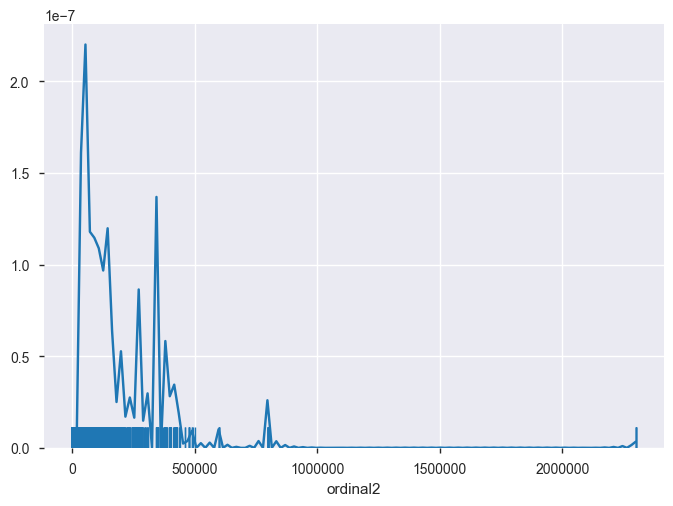

Original Skew Before Coercing Outliers: 22.168451911576177
10%-90% Quantiles: 5.0-3000.0
New Skew After Coercing Outliers: 1.9213814443835882


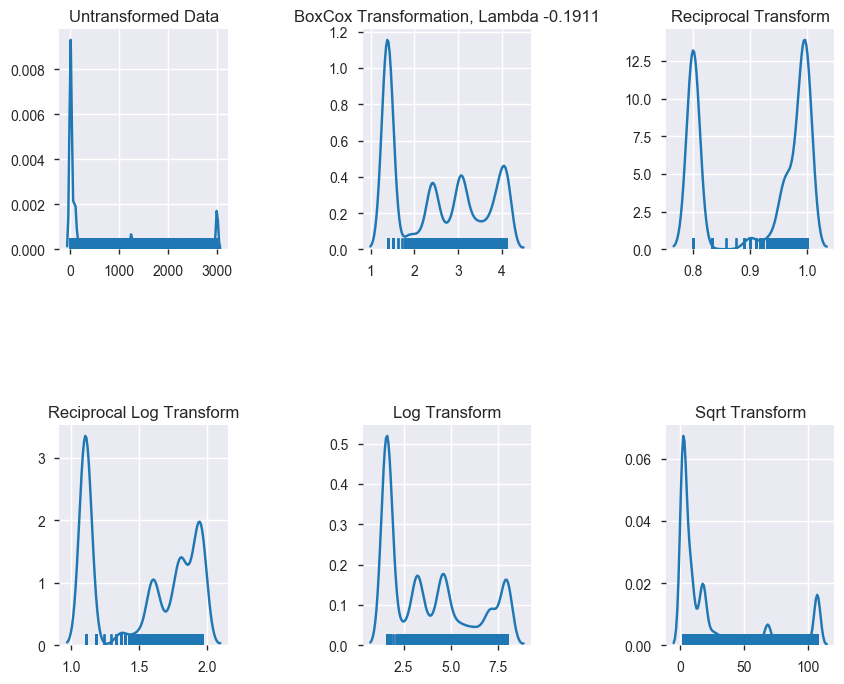

In [11]:
# Review Employees  - Buckets may not be the best course of action due to data gathering; view as continuous

# Review Distribution
ordinal2 = df.ordinal2.dropna().replace(0,1)
sns.distplot(ordinal2, rug=True, hist=False)
plt.show()
print('Original Skew Before Coercing Outliers: {}'.format(pd.Series(ordinal2).skew()))

# Coerce Outliers
eq10 = ordinal2.quantile(0.1)
eq90 = ordinal2.quantile(0.9)
print('10%-90% Quantiles: {}-{}'.format(eq10, eq90))

ordinal2 = np.where(ordinal2 < eq10, eq10, ordinal2)
ordinal2 = np.where(ordinal2 > eq90, eq90 ,ordinal2)
print('New Skew After Coercing Outliers: {}'.format(pd.Series(ordinal2).skew()))

### Review Transformations
transformation_grid(ordinal2)

# While none of the transformations solve the skewness issue, BC with lambda -0.1911 might most useful moving forward

#### Ordinal1

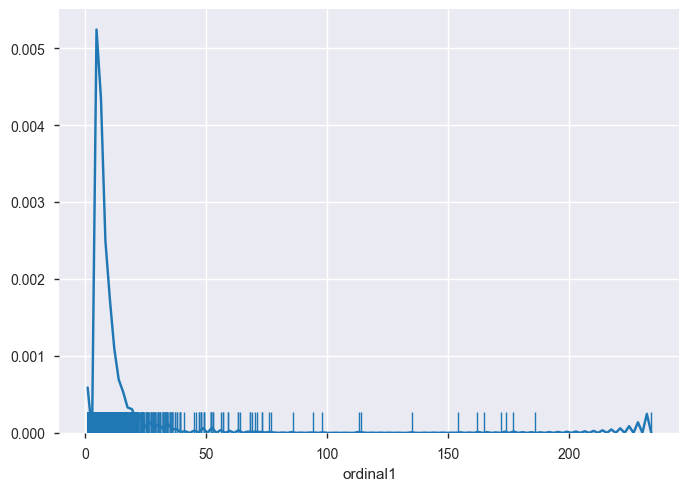

Original Skew Before Coercing Outliers: 31.141020678551453
10%-90% Quantiles: 1.0-1.0


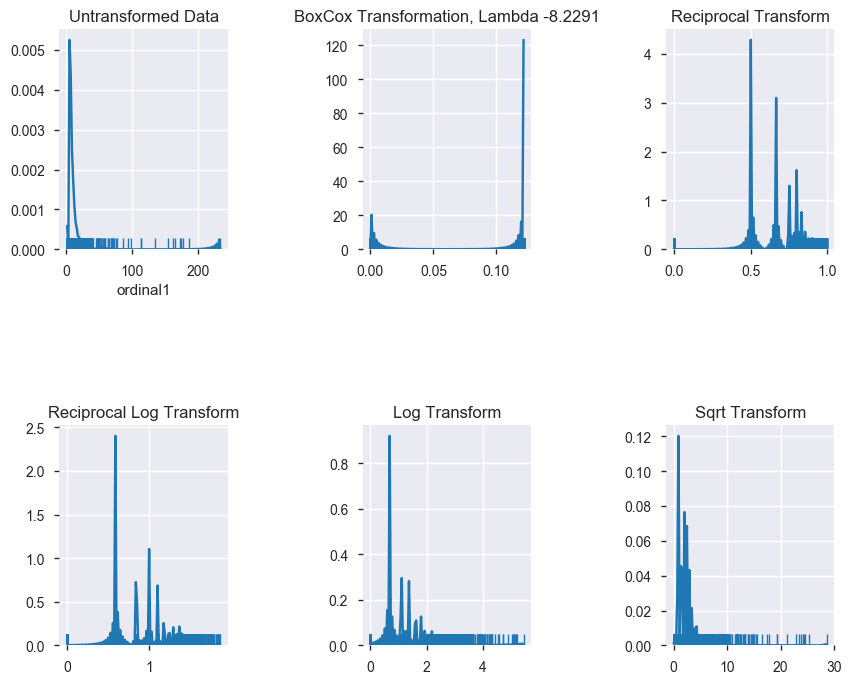

Reciprocal Skewness: 3.2076564525133677
Reciprocal Log Skewness: 3.5167722080594874


In [12]:
# Review Distribution
ordinal1 = df.ordinal1.dropna().replace(0,1)
sns.distplot(ordinal1, rug=True, hist=False)
plt.show()
print('Original Skew Before Coercing Outliers: {}'.format(pd.Series(ordinal1).skew()))

# Coerce Outliers
eq10 = ordinal1.quantile(0.1)
eq90 = ordinal1.quantile(0.9)
print('10%-90% Quantiles: {}-{}'.format(eq10, eq90))

### Replacing outlying values would not be useful as the variable would be monotonic; do not adjust for outliers

# Review transformations
transformation_grid(ordinal1)

# Reciprocal & Reciprocal Log look best - review skewness
print('Reciprocal Skewness: {}'.format(pd.Series(ss.boxcox(ordinal1, -1)).skew()))
print('Reciprocal Log Skewness: {}'.format(pd.Series(ss.boxcox(ordinal1, -0.5)).skew()))

# Recip slightly lower - proceed

For ordinal2, limiting the range between the 10th and 90th percentile greatly decreased the skew. When reviewing transformations, none worked particularly well, but using a BoxCox transformation with lambda -0.1911 seems to be the most beneficial.


For ordinal1, given the incredible proportion that is equal to 1, limiting the values to a range did not seem to make sense. When reviewing transformations, the Reciprocal transformation worked best. 


Moving forward, we will keep ordinal1 and ordinal2 untransformed till after the imputation process. 

### Save Cleaned DataFrame 

In [15]:
# Input NAN 
df = df.replace('nan', np.nan)

# Drop features
df = df.drop(columns=['sector1', 'location1', 'location2', 'signup_date', 'adj_my_signup', 'adj_y_signup'])

# Save as cleaned data
df.to_pickle('cleaned_df.pkl')